# QML for VBS 

## Imports

In [1]:
from qiskit import *
from qiskit import IBMQ, Aer

from qiskit.circuit import ParameterVector
from qiskit.visualization.bloch import Bloch
from qiskit.aqua.components.optimizers import SPSA
from qiskit.tools.monitor import job_monitor

import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np
import math
import time
import pickle
import random 
from random import randrange

In [2]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.1',
 'qiskit-aer': '0.7.2',
 'qiskit-ignis': '0.5.1',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.1',
 'qiskit': '0.23.2'}

## Script parameters
* quantum_hw: set to '0' to use simulator or to '1' to use a real quantum computer;
* bknd: quantum computer used;
* Shots: number of attempts for each measuration to get a statistical result;
* max_circuits_supported: maximum number of circuits supported on Quantum Experience (use an number multiple of number_classes);
* layout: configuration of the qubits chosen from the quantum computer. It links each qubit of the algorithm to the corresponding qubits of the real hardware;
* number_training: number of events of each type used during the training phase;
* number_testing: number of events of each type used during the testing phase;
* SPSA_steps: number of steps for SPSA algorithm;
* number_var: total number of variables used to classify each event;
* number_classes: number of classes for which classification is performed;
* ii,jj,kk,ll,mm : numbers associated to the variables used for the classification of each event (their order is relevant):
* c_e_ii,c_e_jj,c_e_kk,c_e_ll,c_e_mm: crossentropy functions associated to the variables distributions;
* L1: Number of repetitions of the Mapping Circuit;
* L2: Number of repetitions of the Variational part of the Quantum Circuit;
* print_loss_func: 1-> prints the loss function evaluations, 0-> doesn't;
* plot_AUC_image: 1-> prints the AUC graph, 0-> doesn't;
* plot_data: 1-> prints the data images, 0-> doesn't;
* sound: 1-> acustic signal at the end of the execution, 0 -> no signal;
* save_results: 1 -> save result on an externjal file, 0 -> doesn't;


In [3]:
quantum_hw = 0
bknd = 'ibmq_athens'
Shots = 8192                        
max_circuits_supported = 7400        
layout = [0,1,2,3,4]

number_training = 200              
number_testing = 2000
SPSA_steps = 100                     
number_var = 5                      
number_classes = 2                  
ratio = 1

ii = 35
jj = 40
kk = 43
ll = 54 
mm = 45


c_e_ii = 23.807574615434635
c_e_jj = 8.177020948034661
c_e_kk = 7.568297786037082
c_e_ll = 7.194341957347005
c_e_mm = 4.532632440369189 


L1 = 1                 
L2 = 2                 


print_loss_func = 1     
plot_AUC_image = 1      
plot_data = 1 
sound = 0
save_results = 0

## Auxiliary functions

#### Definitions of useful functions
The following are useful to reshape the variables distributions before the mapping phase

In [4]:
def Cheb(x):
    return np.cos((x+1)*np.pi/2)

def InvCheb(x):
    return 2*np.arccos((x+1)/2)/np.pi-1

def Sqrt(x):
    x = np.clip(x,-1,1)
    return np.sqrt((x+1)/2)*2 -1

def InvSqrt(x):
    return ((x+1)**2 -1)/2

#### Labelling function
It labels the input events into the classes (implemented only for 2 classes)

In [5]:
def f_label(i):
    if i%2==0:
        result = [1,0]
    else:
        result = [0,1]
    return result

#### Normalization function (softmax function)

In [6]:
def softmax_function(x):
    F = [math.exp(x[0]),math.exp(x[1]),math.exp(x[2]),math.exp(x[3])]
    for i in range(0,2):
        F[i] = F[i]/sum([math.exp(x[0]),math.exp(x[1])])
    for i in range(2,4):
        F[i] = F[i]/sum([math.exp(x[2]),math.exp(x[3])])
    return F

#### Measuration  function
The following determines how measuration values obtained from the quantum circuit are treated in order to obtain a single result for each event

In [7]:
def f_measuration(count):
    Z_m = np.zeros(4)
    for i in range(0,2**(number_bits)):
        for k in range(0,4):
            if eig[i][1-k] == '0' and eig[i] in count:
                Z_m[k] += count[eig[i]]  

    Z_m = (2*np.array(Z_m)-Shots)/Shots
    y = softmax_function(Z_m)
    return y

#### Mapping function

In [8]:
def Phi_function(x,y,z,a,b):
    return [np.arcsin(y),np.arccos(y**2),np.arcsin(x),np.arccos(x**2),np.arcsin(z),np.arccos(z**2),np.arcsin(a),np.arccos(a**2),np.arcsin(b),np.arccos(b**2)] 
    #the length of the array has to be equal to the number of qubits

## Parameters introduction

In [9]:
def training_set(par,circuit,theta,Phi_f):
    #the following lines are destineted to the creation of the input for bind.parameters()
    pre_input = [[theta.params[k], par[k]] for k in range(0, number_parameters)]
    input_p2 = []
    for i in range(0,len(pre_input)):
        input_p2 = input_p2  + [pre_input[i][0]] + [pre_input[i][1]]
    the_input = [{Phi:Phi_f[i]} for i in range(0,len(X))]
    for i in range(0,len(X)):
        for j in range(0,len(pre_input)):
            the_input[i][pre_input[j][0]] = pre_input[j][1]

    #evaluation of the circuit with the parameters setted by the input, for all possible values in X
    Counts = []
    for j in range(0,N):
        circuits_dataset = [circuit.bind_parameters(the_input[i+j*max_circuits_supported]) for i in range(0,max_circuits_supported)]
        if quantum_hw == 1:
            provider = IBMQ.get_provider('ibm-q')
            qcomp = provider.get_backend(bknd)
        else:
            qcomp = Aer.get_backend('qasm_simulator')
        job = execute(circuits_dataset, backend = qcomp, optimization_level = 0, shots=Shots, initial_layout = layout)
        job_monitor(job)
        result = job.result()
        counts = result.get_counts()
        Counts = Counts + counts

    circuits_dataset = [circuit.bind_parameters(the_input[i+max_circuits_supported*N]) for i in range(0,remainder)]
    if quantum_hw == 1:
        provider = IBMQ.get_provider('ibm-q')
        qcomp = provider.get_backend(bknd)
    else:
        qcomp = Aer.get_backend('qasm_simulator')
    job = execute(circuits_dataset, backend = qcomp, optimization_level = 0, shots=Shots, initial_layout = layout)
    job_monitor(job)
    result = job.result()
    counts = result.get_counts()

    Counts = Counts + counts
    counts = Counts
    
#    ### Just to check that the circuits look right...
#    print(circuits_dataset[0].decompose())
    
    return counts

## Loading data for training
data loading variable-per-variable

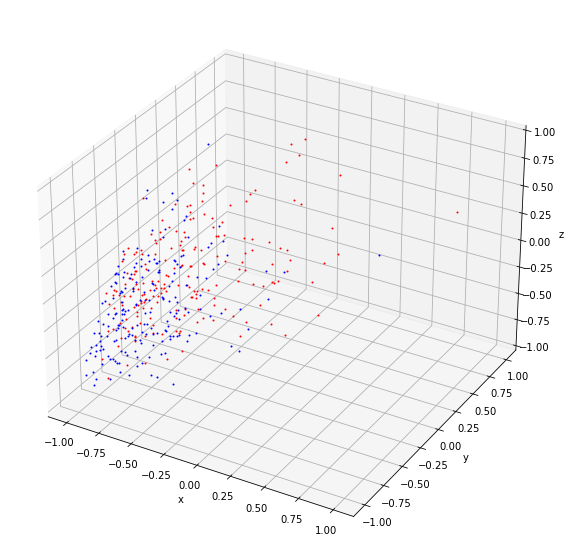

In [10]:
#DATA CAPTURE
#Here data are normalized in [-1,1] and, eventually, "stretched" or "squized" by using the previous functions.
#Odd and even elements of the following vectors will apparain to different classes (by choice)

data2 = pickle.load(open("background_balanced.pkl","rb"))v  
data1 = pickle.load(open("signal_balanced.pkl","rb"))
Ind = data1.columns
#start = randrange(8000)
start = 0

X1 = np.array(data1[Ind[ii]])
X2 = np.array(data2[Ind[ii]])

XX = []
for i in range(start, start + number_training):
    XX.append(X1[i])
    XX.append(X2[i])

Xmax = max(max(XX),max(XX))
Xmin = min(min(XX),min(XX))

X = []
for i in range(0,number_training):
    X.append(X1[i])
    X.append(X2[i])

#X are normalizated over [-1,1]
if Xmax-Xmin!= 0:
    X = (np.array(X)- Xmin)*2/(Xmax-Xmin)
X = np.array(X) -1
#X = Sqrt(X)
X = np.clip(X,-1,1)

############################################################

Y1 = np.array(data1[Ind[jj]])
Y2 = np.array(data2[Ind[jj]])

YY = []
for i in range(start, start + number_training):
    YY.append(Y1[i])
    YY.append(Y2[i])

Ymax = max(max(YY),max(YY))
Ymin = min(min(YY),min(YY))


Y = []
for i in range(0,number_training):
    Y.append(Y1[i])
    Y.append(Y2[i])

#Y are normalizated over [-1,1]
if Ymax-Ymin!= 0:
    Y = (np.array(Y)- Ymin)*2/(Ymax-Ymin)
Y = np.array(Y)  -1
Y = Sqrt(Y)
Y = np.clip(Y,-1,1)

############################################################

Z1 = np.array(data1[Ind[kk]])
Z2 = np.array(data2[Ind[kk]])

ZZ = []
for i in range(start, start + number_training):
    ZZ.append(Z1[i])
    ZZ.append(Z2[i])

Zmax = max(max(ZZ),max(ZZ))
Zmin = min(min(ZZ),min(ZZ))


Z = []
for i in range(0,number_training):
    Z.append(Z1[i])
    Z.append(Z2[i])

#Z are normalizated over [-1,1]
if Zmax-Zmin!= 0:
    Z = (np.array(Z)- Zmin)*2/(Zmax-Zmin)
Z = np.array(Z)  -1
#Z = Cheb(Z)
Z = Sqrt(Z)
Z = np.clip(Z,-1,1)

############################################################
A1 = np.array(data1[Ind[ll]])
A2 = np.array(data2[Ind[ll]])

AA = []
for i in range(start, start + number_training):
    AA.append(A1[i])
    AA.append(A2[i])

Amax = max(max(AA),max(AA))
Amin = min(min(AA),min(AA))


A = []
for i in range(0,number_training):
    A.append(A1[i])
    A.append(A2[i])

#Z are normalizated over [-1,1]
if Amax-Amin!= 0:
    A = (np.array(A)- Amin)*2/(Amax-Amin)
A = np.array(A)  -1
#A = Sqrt(A)
A = np.clip(A,-1,1)

############################################################

B1 = np.array(data1[Ind[mm]])
B2 = np.array(data2[Ind[mm]])

BB = []
for i in range(start, start + number_training):
    BB.append(B1[i])
    BB.append(B2[i])

Bmax = max(max(BB),max(BB))
Bmin = min(min(BB),min(BB))

B = []
for i in range(0,number_training):
    B.append(B1[i])
    B.append(B2[i])

#X are normalizated over [-1,1]
if Bmax-Bmin!= 0:
    B = (np.array(B)- Bmin)*2/(Bmax-Bmin)
B = np.array(B) -1
#X = Sqrt(B)
B = np.clip(B,-1,1)

############################################################

X1 = []
X2 = []
Y1 = []
Y2 = []
Z1 = []
Z2 = []
A1 = []
A2 = []
B1 = []
B2 = []


for i in range(0,len(X)):
    if i % 2 == 0:
        X1.append(X[i])
        Y1.append(Y[i])
        Z1.append(Z[i])
        A1.append(A[i])
        B1.append(B[i])
    else:
        X2.append(X[i])
        Y2.append(Y[i])
        Z2.append(Z[i])
        A2.append(A[i])
        B2.append(B[i])

#TRAINING SET VISUALIZATION
if plot_data == 1:
    %matplotlib inline
    fig = plt.figure(figsize = (10,10)) 
    ax = plt.axes(projection='3d')
    ax.plot3D(X1,Y1,Z1,'ro',markersize = 1)
    ax.plot3D(X2,Y2,Z2,'bo',markersize = 1)
    ax.set_xlabel('x')   
    ax.set_ylabel('y')   
    ax.set_zlabel('z') 

## Preparing for the training
division of the initial vector in smaller vectors in order to fit "max_circuits_supported"

In [11]:
#this part of the program is needed in the case where there exists a maximal number of trainable circuits per-time
N = int(len(X)/max_circuits_supported)

v = np.zeros((N, max_circuits_supported))
for i in range(0,N):
    for j in range(0,max_circuits_supported):
        v[i][j] = X[j+i*max_circuits_supported]
        
remainder = len(X)%max_circuits_supported     
v_last = np.zeros(remainder)
for j in range(0,remainder):
    v_last[j] = X[j+N*max_circuits_supported]

training set mapping function

In [12]:
number_qubits = 1 #for EACH variable
number_bits = number_classes*2

#evaluation of phi
Phi_f = np.zeros((len(X), 2*number_var))
for i in range(0,len(X)):
    for j in range(0, 2*number_var):
        Phi_f[i][j] = Phi_function(X[i],Y[i],Z[i],A[i],B[i])[j]

training set mapping function

In [13]:
#defining the label function for the trainingset, remember that odd and even events correspond to different classes

f_l = []
for i in range(0,len(X)):
    f_l.append(f_label(i))

#### Build the variational circuit

In [14]:
number_parameters = 4*number_qubits*number_var

Phi = ParameterVector('Φ', 2*number_var) #int(number_qubits*(number_qubits+1)/2)
theta = ParameterVector('θ',number_parameters)

## Circuit construction

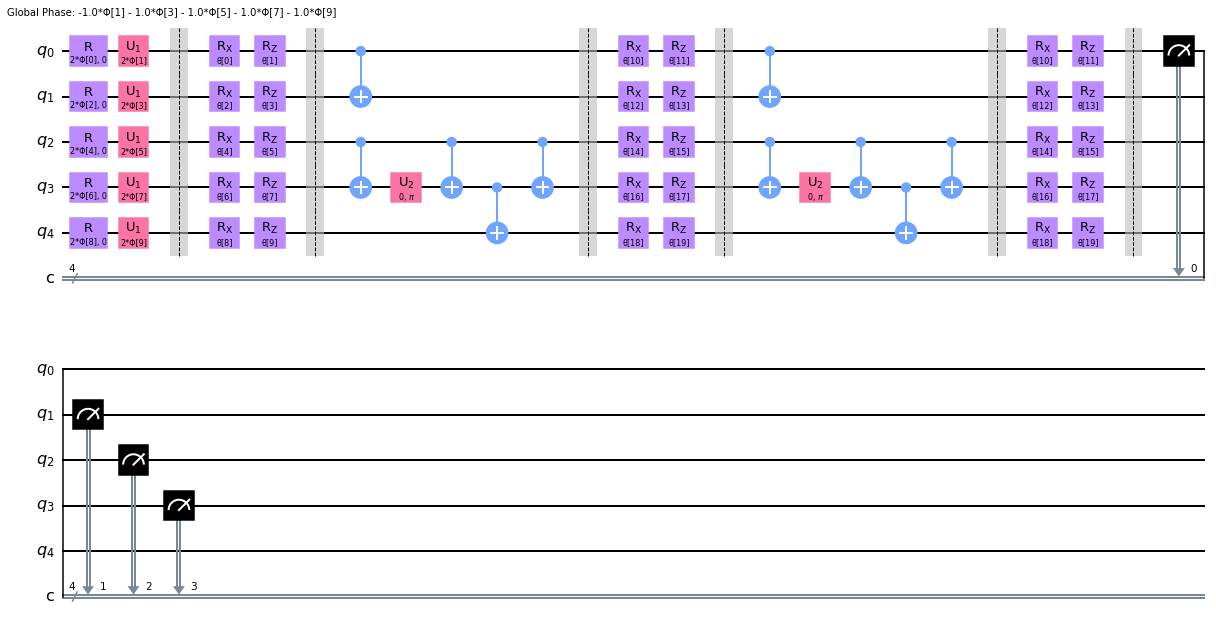

In [15]:
circuit = QuantumCircuit(number_var*number_qubits, number_bits)

for i in range(0,L1):

    for j in range(0,number_var):
        for k in range(0,number_qubits):
            circuit.rx(2*Phi[j*2],j+(number_var)*k)  
            circuit.rz(2*Phi[j*2+1],j+(number_var)*k) 
circuit.barrier()

#rotations
s = 0
for i in range(0,number_qubits*number_var):
    variational_circuit = QuantumCircuit(1)
    variational_circuit.rx(theta[s],0)
    s += 1
    variational_circuit.rz(theta[s],0)
    s += 1
    var_inst = variational_circuit.to_instruction()

    circuit.append(var_inst,[i])
circuit.barrier()
S = s

for k in range(0,L2):    
    #entanglement  

    circuit.cx(0,1)
    circuit.cx(2,3)
    circuit.h(3)
    circuit.cx(2,3)
    circuit.cx(3,4)
    circuit.cx(2,3)

    
    circuit.barrier()
    
    #rotations
    s = S
    for i in range(0,number_qubits*number_var):
        variational_circuit = QuantumCircuit(1)
        variational_circuit.rx(theta[s],0)
        s += 1
        variational_circuit.rz(theta[s],0)
        s += 1
        var_inst = variational_circuit.to_instruction()

        circuit.append(var_inst,[i])
    circuit.barrier()

    
# circuit.measure(range(0,2),range(0,2))
circuit.measure(range(0,4),range(0,4))


%matplotlib inline  
decomposed_circuit = circuit.decompose()
decomposed_circuit.draw('mpl')

## Cost function production and plot

<IPython.core.display.Javascript object>


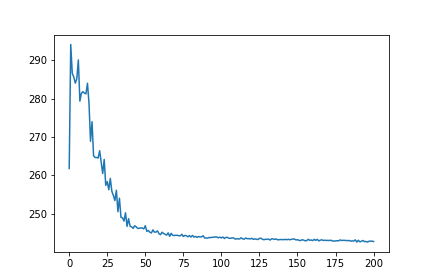

In [16]:
%matplotlib notebook

X_plot = []
Y_plot = []

fig = plt.figure()
ax = fig.add_subplot()
plt.ion()

fig.show()
fig.canvas.draw()
iter_count = 0

def plot_cost_fun(y):
    global iter_count
    global X_plot
    global Y_plot
    X_plot.append(iter_count)
    Y_plot.append(y)
    ax.clear()
    ax.plot(X_plot,Y_plot)
    fig.canvas.draw()
    iter_count += 1   
    


def cost_function(par,*args): #par will contain the parameters at each step of the optimization

    circuit = args[0]
    theta = args[1]
    Phi_f = args[2]
    
    counts = training_set(par,circuit,theta,Phi_f)

    L = 0
    print("\n current value of parameters: " , par )
        
    #estimated label 
    for i in range(0,len(X)):
        for k in range(0,2):
            yi = f_measuration(counts[i])
            Yi = ((c_e_ii+c_e_jj)*yi[k] + (c_e_kk+c_e_ll)*yi[2+k])/(c_e_ii+c_e_jj+c_e_kk+c_e_ll)           
            L += (-f_l[i][k]*math.log(Yi))*(((i+1)%2)*ratio + i%2)
            
    if print_loss_func == 1:
        plot_cost_fun(L)
    
    print("current value for loss function: " , L , "\n\n" )
    return L

## Training

In [17]:
factor = 100

#creation of the eigenstates list, i.e: ['000', '001',... ]
eig = []
for i in range(0,2**(number_bits)):
    eig.append('')

for j in range(0,number_bits):
    for i in range(0,2**j): 
        for k in range(0,(2**(number_bits-j))):            
            if (k % 2) == 0:
                eig[i+k*2**j] = '0' + eig[i+k*2**j] 
            else:
                eig[i+k*2**j] = '1' + eig[i+k*2**j]    

In [18]:
#initial values for parameters are chosen randomly
theta_0 = []


for i in range(0, number_parameters):
    theta_0.append(random.uniform(0, 2*np.pi))
theta_0 = np.array(theta_0)

#In the following c0 is the firt step "a", c1 is the initial "c", c2 is the "alpha" parameter, c3 the "gamma" parameter
#and finally c4 another parameter to control "a" (as like as "alpha" does)
t = time.time()

Optimizer = SPSA(max_trials = 1e3, save_steps = 1, last_avg = 1, c0 = 10/(number_training), c1 = 0.3, c2 = 1, c3 = 0.7, c4 = 0, 
                 skip_calibration = False)

# cost_final, theta_best, cost_plus_save, cost_minus_save, theta_plus_save, theta_minus_save =  (
#     Optimizer._optimization(cost_function,theta_0, SPSA_steps, save_steps = 1, last_avg = 3))

fw = Optimizer.wrap_function(cost_function,(circuit,theta,Phi_f))

cost_final, theta_best, cost_plus_save, cost_minus_save, theta_plus_save, theta_minus_save =  (
    Optimizer._optimization(fw,theta_0, SPSA_steps, save_steps = 1, last_avg = 3) )

print(cost_final,theta_best)

elapsed = time.time() - t
print(elapsed)


C:\Users\dado\anaconda3\lib\site-packages\qiskit\aqua\components\optimizers\spsa.py:93: DeprecationWarning: The max_trials parameter is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use maxiter instead.
  warnings.warn('The max_trials parameter is deprecated as of '


Job Status: job has successfully run

 current value of parameters:  [5.5502309  2.09680168 1.09460633 3.64819707 3.42348789 5.49567344
 1.57485424 0.56267993 1.32836153 1.57425254 1.02260586 2.70344422
 2.17336762 1.86627635 4.66209271 0.98956648 2.32066789 1.03049698
 2.30853887 2.90476408]
current value for loss function:  261.81997642550476 


Job Status: job has successfully run

 current value of parameters:  [ 6.1502309   1.49680168  0.49460633  3.04819707  4.02348789  6.09567344
  0.97485424 -0.03732007  0.72836153  0.97425254  1.62260586  2.10344422
  1.57336762  2.46627635  4.06209271  0.38956648  1.72066789  0.43049698
  1.70853887  2.30476408]
current value for loss function:  294.13201271302074 


Job Status: job has successfully run

 current value of parameters:  [ 2.97288955  4.30479971  3.67194769  6.22553842  0.84614653  3.28767542
  3.78285227  2.77067796  3.90570289  3.78225057 -1.55473549  4.91144225
  4.38136565 -0.34172168  6.87009074  3.56690783  4.52866592  3.6

current value for loss function:  260.5261414628528 


Job Status: job has successfully run

 current value of parameters:  [ 2.09784892  4.11299298  2.73281419  5.24285239  1.15909947  4.04091199
  3.40755409  3.87685246  4.58191391  3.15702075 -0.82711035  6.00700903
  4.47584094 -0.74987672  6.21309555  2.41488136  4.49539372  3.71606512
  3.93669408  4.27689805]
current value for loss function:  264.1911025632291 


Job Status: job has successfully run

 current value of parameters:  [ 2.34527172  3.96520036  2.98023698  5.49027519  1.01130685  4.18870461
  3.65497689  3.62942967  4.82933671  3.40444355 -1.07453315  6.25443183
  4.22841815 -0.6020841   6.36088817  2.26708874  4.24797092  3.86385773
  3.68927128  4.12910543]
current value for loss function:  257.4458520981237 


Job Status: job has successfully run

 current value of parameters:  [ 2.24564154  3.86557018  2.8806068   5.39064501  0.91167667  4.28833479
  3.55534671  3.72905984  4.72970653  3.30481337 -0.97490297  6.1

Job Status: job has successfully run

 current value of parameters:  [ 2.21306755  3.641136    2.85902024  5.34964344  0.95932935  3.81373294
  3.58653033  4.09248788  4.77284877  3.74079442 -1.53173464  6.25041468
  4.40410299 -0.93772467  6.4948978   2.12716729  4.27877462  4.37172867
  3.59629794  4.07880211]
current value for loss function:  246.21927527826932 


Job Status: job has successfully run

 current value of parameters:  [ 2.16057992  3.62875969  2.87139655  5.40213108  0.97170567  3.86622058
  3.5340427   4.14497551  4.76047245  3.68830679 -1.58422227  6.30290231
  4.35161536 -0.88523704  6.50727412  2.17965493  4.29115093  4.4242163
  3.54381031  4.02631448]
current value for loss function:  246.24998338960265 


Job Status: job has successfully run

 current value of parameters:  [ 2.22544386  3.69362364  2.80653261  5.33726713  0.90684172  3.80135663
  3.59890665  4.08011156  4.8253364   3.75317074 -1.51935832  6.23803837
  4.41647931 -0.95010099  6.44241017  2.114790

current value for loss function:  244.93578529091977 


Job Status: job has successfully run

 current value of parameters:  [ 2.29237464  3.55886683  2.98454472  5.43112528  0.88595298  3.68147416
  3.56545697  4.11197084  4.95099021  3.65474375 -1.56043953  6.33254208
  4.40007643 -0.93898805  6.44167152  1.99492081  4.22396633  4.5114719
  3.585391    3.89850153]
current value for loss function:  244.39626178686206 


Job Status: job has successfully run

 current value of parameters:  [ 2.24256613  3.50905831  2.9347362   5.38131676  0.93576149  3.63166564
  3.61526549  4.16177936  4.9011817   3.70455227 -1.51063101  6.28273357
  4.44988495 -0.88917954  6.49148003  2.04472933  4.17415781  4.56128042
  3.53558248  3.94831004]
current value for loss function:  244.39267465625701 


Job Status: job has successfully run

 current value of parameters:  [ 2.24294954  3.55827766  2.98395554  5.4305361   0.88654215  3.68088499
  3.56604615  4.16139595  4.95040104  3.70416886 -1.55985035  6

Job Status: job has successfully run

 current value of parameters:  [ 2.23224391  3.47627179  2.97316812  5.44529374  0.91250354  3.60414823
  3.63035068  4.151772    4.97273793  3.69196437 -1.52661407  6.31626872
  4.47218699 -0.95600694  6.49714779  1.9678343   4.19539627  4.53661129
  3.57954429  3.9243621 ]
current value for loss function:  243.72254749149022 


Job Status: job has successfully run

 current value of parameters:  [ 2.27337978  3.51740767  2.93203225  5.40415786  0.87136766  3.64528411
  3.58921481  4.11063612  4.93160205  3.6508285  -1.56774995  6.3574046
  4.51332286 -0.99714282  6.45601191  2.00897018  4.15426039  4.57774717
  3.53840842  3.88322623]
current value for loss function:  243.6941546695584 


Job Status: job has successfully run

 current value of parameters:  [ 2.23330146  3.47732935  2.93158932  5.40371494  0.87092474  3.64572703
  3.62929313  4.15071444  4.97168037  3.69090682 -1.52767163  6.31732628
  4.47324454 -0.99758574  6.45556899  2.0094131

current value for loss function:  243.4695687360504 


Job Status: job has successfully run

 current value of parameters:  [ 2.27894132  3.49257109  2.96084831  5.42104822  0.85076357  3.62978016
  3.58805904  4.12538729  4.93212218  3.64602775 -1.58744698  6.38084269
  4.48957729 -1.01272385  6.44419719  2.01891221  4.14035263  4.5792528
  3.51534819  3.93671634]
current value for loss function:  243.7795583904734 


Job Status: job has successfully run

 current value of parameters:  [ 2.23607187  3.44970163  2.91797885  5.42894317  0.89363303  3.5869107
  3.63092849  4.13328224  4.97499163  3.6888972  -1.54457752  6.37294775
  4.49747224 -1.0048289   6.48706664  2.01101726  4.14824757  4.57135786
  3.55821764  3.9288214 ]
current value for loss function:  243.47937331075045 


Job Status: job has successfully run

 current value of parameters:  [ 2.27104638  3.48467614  2.95295336  5.46391768  0.85865852  3.62188521
  3.59595398  4.16825675  4.94001712  3.65392269 -1.57955204  6.33

Job Status: job has successfully run

 current value of parameters:  [ 2.23525251  3.42005529  2.93724187  5.44389533  0.91511696  3.6323007
  3.62506458  4.13560613  4.94175261  3.67892383 -1.60369352  6.38385255
  4.51546614 -0.98608672  6.47365926  2.00262445  4.17994747  4.54188277
  3.5477123   3.88255998]
current value for loss function:  243.34867292649375 


Job Status: job has successfully run

 current value of parameters:  [ 2.26357787  3.44838065  2.93988762  5.44124958  0.91776271  3.60397533
  3.59673922  4.13296037  4.97007798  3.65059846 -1.60633927  6.35552719
  4.51282038 -0.98873247  6.47630501  2.0052702   4.20827283  4.53923702
  3.51938694  3.87991423]
current value for loss function:  243.46976278888548 


Job Status: job has successfully run

 current value of parameters:  [ 2.23260675  3.41740953  2.90891651  5.4722207   0.88679159  3.63494645
  3.62771034  4.16393149  4.93910686  3.68156958 -1.57536815  6.3864983
  4.5437915  -0.95776136  6.44533389  1.9742990

current value for loss function:  243.38060309406904 


Job Status: job has successfully run

 current value of parameters:  [ 2.23922638  3.41543009  2.91657382  5.46568116  0.88302221  3.61292496
  3.63066476  4.1750761   4.96506075  3.70654153 -1.58683986  6.35320809
  4.56364591 -0.94924783  6.47292473  2.00661063  4.1831843   4.57523397
  3.52788212  3.87505673]
current value for loss function:  243.1267000324548 


Job Status: job has successfully run

 current value of parameters:  [ 2.26715107  3.3875054   2.94449851  5.43775648  0.91094689  3.64084964
  3.60274007  4.14715142  4.93713607  3.67861685 -1.61476455  6.38113277
  4.53572123 -0.97717251  6.50084942  1.97868594  4.15525962  4.54730929
  3.5558068   3.90298142]
current value for loss function:  243.1938258144968 


Job Status: job has successfully run

 current value of parameters:  [ 2.23784489  3.38912868  2.94287524  5.43937975  0.88164071  3.61154346
  3.60436334  4.1764576   4.93875934  3.70792303 -1.61314128  6.

Job Status: job has successfully run

 current value of parameters:  [ 2.27300283  3.37660984  2.93419286  5.47219559  0.90734495  3.62144514
  3.636268    4.16380098  4.96498911  3.67909041 -1.63534816  6.36587367
  4.5619095  -0.95829145  6.51208609  1.97742313  4.14408069  4.54820161
  3.52193732  3.91577482]
current value for loss function:  243.12037633614597 


Job Status: job has successfully run

 current value of parameters:  [ 2.24748626  3.40212641  2.95970943  5.44667902  0.88182838  3.64696171
  3.61075143  4.18931755  4.93947254  3.70460698 -1.60983159  6.39139024
  4.53639293 -0.98380802  6.48656952  2.0029397   4.16959726  4.57371818
  3.54745389  3.89025825]
current value for loss function:  243.08282799447736 


Job Status: job has successfully run

 current value of parameters:  [ 2.24677497  3.37751561  2.96042073  5.47128982  0.88111708  3.64767301
  3.61004014  4.19002884  4.96408334  3.67999617 -1.60912029  6.39210154
  4.56100374 -0.95919721  6.48585822  2.00365

## Load data for testing
data loading variable-per-variable

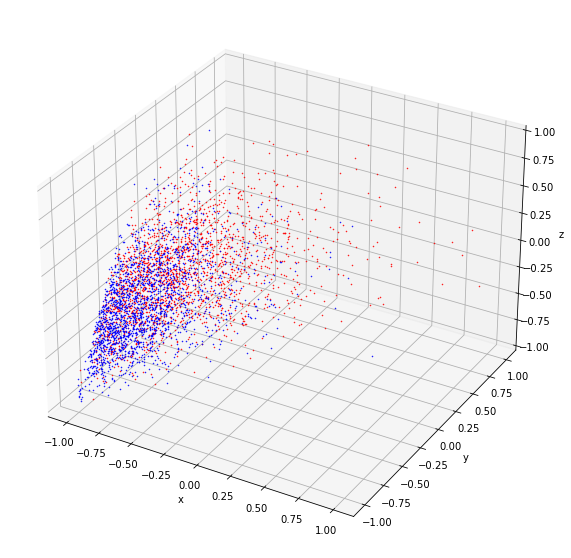

In [19]:
#data capture
# data2 = pickle.load(open("Wjets_part1.pkl","rb"))
# data1 = pickle.load(open("VBS_part1.pkl","rb"))
# Ind = data1.columns


X1 = np.array(data1[Ind[ii]])
X2 = np.array(data2[Ind[ii]])

X = []
for i in range(start + number_training, start + number_training + number_testing):
    X.append(X1[i])
    X.append(X2[i])

#X are normalizated over [-1,1]
if Xmax-Xmin!= 0:
    X = (np.array(X)- Xmin)*2/(Xmax-Xmin)
X = np.array(X) -1
#X = Sqrt(X)
X = np.clip(X,-1,1)

############################################################

Y1 = np.array(data1[Ind[jj]])
Y2 = np.array(data2[Ind[jj]])


Y = []
for i in range(start + number_training, start + number_training + number_testing):
    Y.append(Y1[i])
    Y.append(Y2[i])

#Y are normalizated over [-1,1]
if Ymax-Ymin!= 0:
    Y = (np.array(Y)- Ymin)*2/(Ymax-Ymin)
Y = np.array(Y)-1
Y = Sqrt(Y)
Y = np.clip(Y,-1,1)

############################################################

Z1 = np.array(data1[Ind[kk]])
Z2 = np.array(data2[Ind[kk]])

Z = []
for i in range(start + number_training, start + number_training + number_testing):
    Z.append(Z1[i])
    Z.append(Z2[i])

#Z are normalizated over [-1,1]
if Zmax-Zmin!= 0:
    Z = (np.array(Z)- Zmin)*2/(Zmax-Zmin)
Z = np.array(Z)-1
#Z = Cheb(Z)
Z = Sqrt(Z)
Z = np.clip(Z,-1,1)

############################################################

A1 = np.array(data1[Ind[ll]])
A2 = np.array(data2[Ind[ll]])

A = []
for i in range(start + number_training, start + number_training + number_testing):
    A.append(A1[i])
    A.append(A2[i])

#Z are normalizated over [-1,1]
if Amax-Amin!= 0:
    A = (np.array(A)- Amin)*2/(Amax-Amin)
A = np.array(A)  -1
#A = Sqrt(A)
A = np.clip(A,-1,1)

############################################################

B1 = np.array(data1[Ind[mm]])
B2 = np.array(data2[Ind[mm]])

B = []
for i in range(start + number_training, start + number_training + number_testing):
    B.append(B1[i])
    B.append(B2[i])

#Z are normalizated over [-1,1]
if Bmax-Bmin!= 0:
    B = (np.array(B)- Bmin)*2/(Bmax-Bmin)
B = np.array(B)  -1
#B = Sqrt(B)
B = np.clip(B,-1,1)

############################################################ 

X1 = []
X2 = []
Y1 = []
Y2 = []
Z1 = []
Z2 = []
A1 = []
A2 = []
B1 = []
B2 = []

for i in range(0,len(X)):
    if i % 2 == 0:
        X1.append(X[i])
        Y1.append(Y[i])
        Z1.append(Z[i])
        A1.append(A[i])
        B1.append(B[i])
    else:
        X2.append(X[i])
        Y2.append(Y[i])
        Z2.append(Z[i])
        A2.append(A[i])
        B2.append(B[i])

#TESTING SET VISUALIZATION
if plot_data == 1:
    %matplotlib inline
    fig = plt.figure(figsize = (10,10)) 
    ax = plt.axes(projection='3d')
    ax.plot3D(X1,Y1,Z1,'ro',markersize = 0.5)
    ax.plot3D(X2,Y2,Z2,'bo',markersize = 0.5)
    ax.set_xlabel('x')   
    ax.set_ylabel('y')   
    ax.set_zlabel('z')  

## Preparing for testing
division of the initial vector in smaller vectors in order to fit "max_circuits_supported"

In [20]:
N = int(len(X)/max_circuits_supported)

v = np.zeros((N, max_circuits_supported))
for i in range(0,N):
    for j in range(0,max_circuits_supported):
        v[i][j] = X[j+i*max_circuits_supported]
        
remainder = len(X)%max_circuits_supported     
v_last = np.zeros(remainder)
for j in range(0,remainder):
    v_last[j] = X[j+N*max_circuits_supported]

testing set mapping function

In [21]:
Phi_f = np.zeros((len(X), 2*number_var))
for i in range(0,len(X)):
    for j in range(0, 2*number_var):
        Phi_f[i][j] = Phi_function(X[i],Y[i],Z[i],A[i],B[i])[j]

traing set labels

In [22]:
f_l = []
for i in range(0,len(X)):
    f_l.append(f_label(i))

## Testing & AUC

#### ROC production

In [ ]:
%matplotlib inline  
if plot_AUC_image == 1:
    fig2 = plt.figure(figsize = (10,10)) 
    plt.ylim((0,1))
    plt.xlim((0,1))

counts = training_set(theta_best,circuit,theta,Phi_f)

index_sorted = []
classification = []
for i in range(0,len(X)):
    classification.append(((c_e_ii+c_e_jj)*f_measuration(counts[i])[0]+(c_e_kk+c_e_ll)*f_measuration(counts[i])[2])/(c_e_ii+c_e_jj+c_e_kk+c_e_ll)) 

sort_index = np.argsort(classification)

Classification = []
Labelling = []
for i in range(0,len(X)):
    Classification.append(((c_e_ii+c_e_jj)*f_measuration(counts[sort_index[i]])[0]+(c_e_kk+c_e_ll)*f_measuration(counts[sort_index[i]])[2])/(c_e_ii+c_e_jj+c_e_kk+c_e_ll))  
    Labelling.append((sort_index[i]+1)%2)

treshold = np.linspace(0,1,2000)
False_positive_rate = []
True_positive_rate = []

for k in range(0,len(treshold)):
    C = Classification > treshold[k]
    false_negatives = sum((Labelling - C) == np.int_(np.ones(len(X))))
    false_positives = sum(np.array(Labelling - C) ==np.int_(-np.ones(len(X)))) 
    true_positives = sum(Labelling) - false_negatives 
    true_negatives = sum((Labelling) == np.int_(np.zeros(len(X)))) - false_positives

    False_positive_rate.append(false_positives/(false_positives+true_negatives+0.000001))
    True_positive_rate.append(true_positives/(true_positives+false_negatives+0.000001))
    if plot_AUC_image == 1:
        plt.plot(False_positive_rate[k],True_positive_rate[k],'ro',label = "ROC", markersize=3)
        
if plot_AUC_image == 1:    
    plt.plot(treshold,treshold,'b', markersize=3)                  

Job Status: job is actively running

#### AUC evaluation
(should be improved with Simpson rule)

In [ ]:
def sorter(x,y):
    index = np.zeros(len(x))
    for k in range(0,len(x)):
        min = x[k]
        index[k] = k
        for i in range(k,len(x)):
            if x[i] < min:
                index[k] = i
        buffer = x[k] 
        x[k] = x[int(index[k])]
        x[int(index[k])] = buffer
        buffer = y[k] 
        y[k] = y[int(index[k])]
        y[int(index[k])] = buffer
    return x,y
    
False_positive_rate, True_positive_rate = sorter(False_positive_rate, True_positive_rate)

AUC = 0
for k in range(0,len(False_positive_rate)-1):
    AUC += (True_positive_rate[k]+True_positive_rate[k+1])*(False_positive_rate[k+1]-False_positive_rate[k])/2

print(AUC)

#### Resulting visualzation

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline  
fig = plt.figure(figsize = (10,10)) 
ax = plt.axes(projection='3d')

classificator = []
f_m = []
for i in range(0,len(X)):
    f_m.append(((c_e_ii+c_e_jj)*f_measuration(counts[i])[0]+(c_e_kk+c_e_ll)*f_measuration(counts[i])[2])/(c_e_ii+c_e_jj+c_e_kk+c_e_ll))

Min = min(f_m)
Max = max(f_m)
delta = Max - Min
    
for i in range(0,len(X)):
    x = [X[i]]
    y = [Y[i]]
    z = [Z[i]]
    ax.plot3D(x,y,z,'o',color = [np.clip((((c_e_ii+c_e_jj)*f_measuration(counts[i])[0]+(c_e_kk+c_e_ll)*f_measuration(counts[sort_index[i]])[2])/(c_e_ii+c_e_jj+c_e_kk+c_e_ll)-Min)/delta,0,1), 0, np.clip(1-(((c_e_ii+c_e_jj)*f_measuration(counts[i])[0]+(c_e_kk+c_e_ll)*f_measuration(counts[sort_index[i]])[2])/(c_e_ii+c_e_jj+c_e_kk+c_e_ll)-Min)/delta,0,1)] ,markersize = 0.5)

if sound == 1:
    import winsound
    frequency = 1000  # Set Frequency To 2500 Hertz
    duration = 1000 # Set Duration To 1000 ms == 1 second
    winsound.Beep(frequency, duration)

## Saving results on file

In [ ]:
if save_results == 1:     
    file1 = open("real_device_record.txt","a")
    FP = str(False_positive_rate).strip('[]')
    TP = str(True_positive_rate).strip('[]')
    FM = str(f_m).strip('[]')

    file1.write("BEGIN ATTEMPT \n\n")
    file1.write("number_training = %d \n\n" %number_training)
    file1.write("number_testing = %d \n\n" %number_testing)
    file1.write("SPSA_steps = %d \n\n" %SPSA_steps)
    file1.write("number_var = %d \n\n" %number_var)
    file1.write("variables: %d " %ii + "% d " %jj + "%d \n\n" %kk)
    file1.write("AUC = %d \n\n" %AUC)

    file1.write("False Positives: \n\n"+FP+ "\n\n"+"True Positives: \n\n"+TP+ "\n\n"+"f_measuration: \n\n"+FM + "\n\n\n\n\n")
    file1.close() 